### Synthetic 3D Segmentation Dataset — Data Exploration
This notebook explores the structure of the synthetic 3D point cloud segmentation dataset.

Goals:

* Inspect file structure
* Load `.npz` scene files
* Verify metadata (`classes.json`, `splits.json`)
* Visualize point clouds (RGB + labels)
* Compute basic statistics


In [11]:
## 1️ Setup
import os
import json
import numpy as np
from pathlib import Path
from collections import Counter

DATA_ROOT = Path("../data/input")  # adjust if needed

np.set_printoptions(suppress=True)

In [12]:
## 2️ Check scene files
npz_files = sorted(DATA_ROOT.glob("scene_*.npz"))
ply_files = sorted(DATA_ROOT.glob("scene_*.ply"))

if npz_files:
    print(f"NPZ scenes: {len(npz_files)}")
    print(f"PLY scenes: {len(ply_files)}")
    print("Example file:", npz_files[0])
else:
    print(f"No data file found under {DATA_ROOT}, the DATA_ROOT shoud point to a folder containing the npz and ply files")

NPZ scenes: 10
PLY scenes: 10
Example file: ..\data\input\scene_00.npz


In [ ]:
## 3️ Load Metadata
with open(DATA_ROOT / "classes.json") as f:
    classes = json.load(f)

with open(DATA_ROOT / "splits.json") as f:
    splits = json.load(f)

print("Classes:")
print(classes)

print("\nSplits:")
print(splits)

Classes:
{'0': 'background', '1': 'ground', '2': 'box', '3': 'sphere', '4': 'cylinder'}

Split sizes:
{'train': [0, 1, 2, 3, 4, 5, 6], 'val': [7, 8], 'test': [9]}


In [ ]:
## 4️ Load a Scene
scene_path = npz_files[0]
data = np.load(scene_path)

xyz = data["xyz"]
rgb = data["rgb"]
labels = data["labels"]

print("xyz min max:",xyz.min(), xyz.max())
print("xyz shape:", xyz.shape)
print("rgb shape:", rgb.shape)
print("labels shape:", labels.shape)

print("xyz dtype:", xyz.dtype)
print("rgb dtype:", rgb.dtype)
print("labels dtype:", labels.dtype)

# Sanity checks
assert xyz.shape[1] == 3
assert rgb.shape[1] == 3
assert len(xyz) == len(labels)

xyz shape: (60000, 3)
rgb shape: (60000, 3)
labels shape: (60000,)
xyz dtype: float32
rgb dtype: float32
labels dtype: int64


Class 1 (ground): 30000 points
Class 2 (box): 10000 points
Class 3 (sphere): 10000 points
Class 4 (cylinder): 10000 points


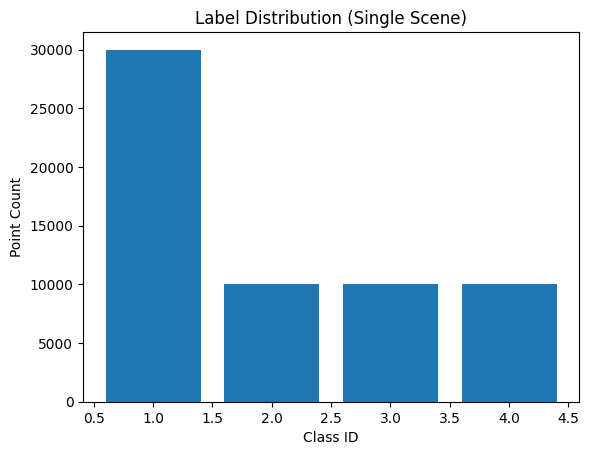

In [16]:
## 5️ Label Distribution (Single Scene)
import matplotlib.pyplot as plt
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u} ({classes[str(u)]}): {c} points")

plt.bar(unique, counts)
plt.title("Label Distribution (Single Scene)")
plt.xlabel("Class ID")
plt.ylabel("Point Count")
plt.show()

In [25]:
npz_files

[WindowsPath('../data/input/scene_00.npz'),
 WindowsPath('../data/input/scene_01.npz'),
 WindowsPath('../data/input/scene_02.npz'),
 WindowsPath('../data/input/scene_03.npz'),
 WindowsPath('../data/input/scene_04.npz'),
 WindowsPath('../data/input/scene_05.npz'),
 WindowsPath('../data/input/scene_06.npz'),
 WindowsPath('../data/input/scene_07.npz'),
 WindowsPath('../data/input/scene_08.npz'),
 WindowsPath('../data/input/scene_09.npz')]

In [34]:
## 6 3D Visualization (RGB colored)
# This cell will open another window for 3D rending
import open3d as o3d

scene_path = npz_files[8]
data = np.load(scene_path)

xyz = data["xyz"]
rgb = data["rgb"]
labels = data["labels"]

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(rgb)

# Show inline
o3d.visualization.draw_geometries([pcd])

In [40]:
## Alternative visualization colored by label


scene_path = npz_files[6]
data = np.load(scene_path)

xyz = data["xyz"]
rgb = data["rgb"]
labels = data["labels"]

# Create colormap (tab10 works well for small number of classes)
cmap = plt.get_cmap("tab10")

# Normalize labels to [0, 1] for colormap indexing
num_classes = labels.max() + 1
colors = cmap(labels / max(1, num_classes - 1))[:, :3]  # keep RGB only

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Visualize
o3d.visualization.draw_geometries([pcd])

Total scenes: 10
Avg points per scene: 60000.0
Min points per scene: 60000
Max points per scene: 60000

Global class distribution:
Class 1 (ground): 300000 points
Class 2 (box): 100000 points
Class 3 (sphere): 100000 points
Class 4 (cylinder): 100000 points


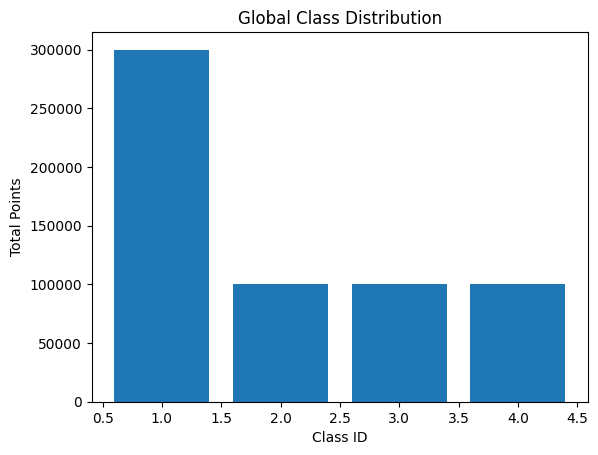

In [ ]:
## 8️ Dataset-Wide Statistics
all_counts = Counter()
num_points = []

for file in npz_files:
    data = np.load(file)
    labels = data["labels"]

    num_points.append(len(labels))
    unique, counts = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts):
        all_counts[u] += c

print("Total scenes:", len(npz_files))
print("Avg points per scene:", np.mean(num_points))
print("Min points per scene:", np.min(num_points))
print("Max points per scene:", np.max(num_points))

print("\nGlobal class distribution:")
for k in sorted(all_counts.keys()):
    print(f"Class {k} ({classes[str(k)]}): {all_counts[k]} points")

# Plot global distribution
ids = sorted(all_counts.keys())
counts = [all_counts[k] for k in ids]

plt.bar(ids, counts)
plt.title("Global Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Total Points")
plt.show()

# Summary

This notebook verifies:

* Correct scene file structure
* Data shapes and types
* Label distribution (per-scene and global)
* Basic 3D visualization (RGB + labels)

Next steps:

* Implement per-class IoU
* Build a dataloader
* Visualize predictions vs ground truth
